# Dice Simulation

JMA July 2024

A simulation based on Kelly-investment strategy to demonstrate sequential hedging and risk taking

In [304]:
import pickle
from pathlib import Path
import numpy as np
from numpy.random import default_rng
import pandas as pd
import seaborn as sns

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span
from bokeh.io import output_notebook
output_notebook()

rng = default_rng(seed=100)

DICE_SIDES = 60
DICE_THRESHOLD = 31
NUM_PERIODS = 4000 # 000
WIN_BETA_PRIORS = {"a": 1, "b":1}
SIMULATION_COUNT = 1000
PKL_FILENAME = f'trajectories_{NUM_PERIODS}_by_{SIMULATION_COUNT}.pkl'


Loading BokehJS ...

In [305]:
def beta_mean(beta):
    return beta['a']/(beta['a'] + beta['b'])

def fair_win_probability(sides=DICE_SIDES, win_thresh= DICE_THRESHOLD):
    "Probability of a winning investment"
    fair_win = win_thresh / sides
    return fair_win

fair_win_p = fair_win_probability()
f'Probability of an investment win: {fair_win_p:.3},  Prior {beta_mean(WIN_BETA_PRIORS):.3}'

'Probability of an investment win: 0.517,  Prior 0.5'

In [306]:
def win_prob_estimate(win_or_loss, priors):
    'Assume a beta distribution. Do an update assuming a binomial process'
    if win_or_loss == 1:
        priors['a'] +=1
    else:
        priors['b'] +=1
    beta_mean = priors['a'] /(priors['a']+ priors['b'])
    return beta_mean, priors

def investment_process(true_win_p, rounds=NUM_PERIODS):
    'A sequence of 1s and 0s, with win == 1, loss = 0. For the true win stochastic process.'
    return rng.binomial(1, true_win_p, rounds)

def beta_update(wins, prior=WIN_BETA_PRIORS, rounds=NUM_PERIODS):
    'For the unobserved actual win sequence  compute the observed, estimated win prob update.'
    win_estimates = np.zeros(rounds)
    for k, a_win in enumerate(wins):
        win_estimates[k], prior = win_prob_estimate(a_win, prior)
    return win_estimates, prior
    
wins = investment_process(fair_win_p)
win_p_estimates, prior = beta_update(wins)
f'Beta parameters: {params}, mean: {b_mean}'
win_p_estimates, prior


(array([0.33333333, 0.25      , 0.4       , ..., 0.51675   , 0.51687078,
        0.5169915 ]),
 {'a': 2069, 'b': 1933})

In [307]:
estimate_cds = ColumnDataSource(pd.DataFrame({'estimate': win_p_estimates}).reset_index())
p= figure(
        title="Running Bayes estimate of win probability. ",
        y_range=(min(0.98 *fair_win_p, np.min(win_p_estimates)), max(1.02 *fair_win_p, np.max(win_p_estimates))),
        width = 900, height = 480)
p.line(x='index', y='estimate', source=estimate_cds)
actual_p = Span(location=fair_win_p, dimension='width', line_dash='dotdash')
p.renderers.extend([actual_p])
show(p)

In [308]:
def kelly_rule(p):
    'The fraction to bet for an assumed win probability'
    # This works as a vectorized function 
    return ((2*p - 1) * (p > 0.5))


def log_wealth_trajectory(wins, win_p_estimate):
    """
    Use the estimated win probability update as the bet fraction, using the Kelly rule
    """
    # The log increment for a win is different than for a loss -- is that a problem? 
    log_inc = np.log(1+ (2*wins-1) * kelly_rule(win_p_estimate))
    trajectory = np.cumsum(log_inc)
    return trajectory

In [309]:
a_trajectory = log_wealth_trajectory(wins, win_p_estimates)
trajectory_cds = ColumnDataSource(pd.DataFrame({'trajectory': a_trajectory}).reset_index())
p= figure(
        title="Log value over multiple rounds. ",
        #y_range=(min(0.98 *fair_win_p, np.min(win_p_estimate[0])), max(1.02 *fair_win_p, np.max(win_p_estimate[0]))),
        width = 900, height = 480)
p.line(x='index', y='trajectory', source=trajectory_cds, line_color='darkred')
# actual_p = Span(location=fair_win_p, dimension='width', line_dash='dotdash')
# p.renderers.extend([actual_p])
show(p)

In [310]:



# Careful to reset the prior for each simulation
def run_simulations(fair_win_p, prior=WIN_BETA_PRIORS, simulations=SIMULATION_COUNT):
    """ 
"""
    trajectories = np.zeros((NUM_PERIODS, simulations ))
    for a_sim in range(simulations):
        wins = investment_process(fair_win_p)
        win_p_estimates, prior =beta_update(wins, prior)
        a_trajectory = log_wealth_trajectory(wins, win_p_estimates)
        print('.', end='')
        trajectories[:,a_sim] = a_trajectory

    return trajectories



In [311]:
#SIMULATION_COUNT = 10
simulated_trajectories = run_simulations(fair_win_p, simulations=SIMULATION_COUNT)
pd.DataFrame(simulated_trajectories).describe()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.313909,2.443893,-0.294067,1.001345,1.437876,0.887572,0.349668,4.033679,0.472343,0.874878,...,2.120476,0.064566,1.624045,-0.025860,2.882997,0.944845,2.226592,0.066299,2.512498,1.144284
std,0.723693,1.298584,0.467731,0.599651,0.799045,1.036916,0.514842,2.161721,0.796963,0.412752,...,0.932151,0.570090,1.197157,0.309015,1.205477,0.455429,1.492820,0.893769,2.388680,1.225118
min,-0.922343,-0.209490,-1.278312,-0.064149,-0.206385,-0.973270,-0.861967,-0.031419,-1.121481,-0.098836,...,0.027952,-1.419135,-0.747366,-1.107459,-0.078856,-0.438682,-0.760700,-1.582872,-0.987971,-1.003794
25%,-0.313214,1.457590,-0.700543,0.489975,0.869959,-0.257811,-0.022040,2.085087,-0.073137,0.613272,...,1.635297,-0.229606,0.690814,-0.212025,2.252486,0.801221,1.408355,-0.899678,0.111849,0.170952
50%,0.340496,2.569661,-0.169459,0.815761,1.294772,1.060422,0.343742,4.679140,0.235638,0.896781,...,2.169069,0.183608,1.656018,0.003822,2.970260,1.013327,1.943539,0.396151,2.624700,0.990607
75%,0.907889,3.384508,0.069527,1.487023,1.936779,1.829882,0.784455,5.989940,0.757789,1.199422,...,2.885377,0.429331,2.621153,0.188278,3.982046,1.243067,3.148329,0.673503,4.268977,1.948473
max,1.707833,5.074082,0.695395,2.429610,3.473106,2.792926,1.435571,6.864966,2.667538,1.721467,...,4.132813,1.105142,3.932252,0.885097,4.720354,1.972753,5.554780,1.736485,6.804274,3.870165


<Axes: ylabel='Count'>

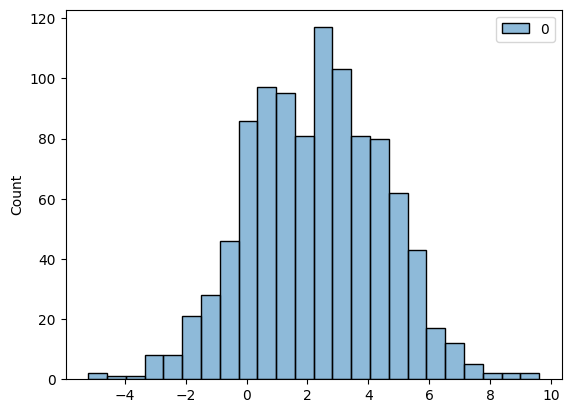

In [312]:
sns.histplot(simulated_trajectories[-1:].T)


In [314]:

if not Path(PKL_FILENAME).exists():
    pickle.dump(simulated_trajectories, open(PKL_FILENAME, 'wb'))
else:
    results = pickle.load(open(PKL_FILENAME, 'rb'))